### Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
import copy

In [2]:
%matplotlib inline

In [3]:
# converting color mode to RGB and displaying the image as matplotlib figure
def matplotlib_imshow(
    img_title="", img=None, fig_h=7, cv_colorspace_conversion_flag=cv.COLOR_BGR2RGB
):
    # tinkering with size
    try:
        img_width, img_height = img.shape[0], img.shape[1]
        aspect_ratio = img_width / img_height
        plt.figure(figsize=(fig_h * aspect_ratio, fig_h))
    except AttributeError:
        print(
            "None Type image. Correct_syntax is, matplotlib_imshow(img_title, img, fig_h, cv_colorspace_conversion_flag)."
        )

    # actual code for displaying the image
    plt.imshow(cv.cvtColor(img, cv_colorspace_conversion_flag))
    plt.title(img_title)
    plt.show()

In [4]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
    # return the edged image
    return edged

## Contours ([Docs]())

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

<img src='./imgs/contour_example.jpeg' height=500>

**Note:** A useful Resource for learning about Contours in OpenCv along with the OpenCV documentation might be [This One](https://bleedaiacademy.com/contour-detection-101-the-basics-pt1/).

- ### Finding Contours

In OpenCV, finding contours is like finding white object from black background. So remember, `object to be found should be white and background should be black.`

> The `cv.findContours(image, mode, method)` function

<u>Function Parameters</u>
- image: source image (an 8-bit single-channel image). Non-zero pixels are treated as 1's. Zero pixels remain 0's i.e, the image is treated as binary. **So, before finding contours, apply threshold or canny edge detection.**
- mode: contour retrieval mode. The available [retrieval modes](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71) are,
    - cv.RETR_EXTERNAL: retrieves only the extreme outer contours.
    - cv.RETR_LIST: retrieves all of the contours without establishing any hierarchical relationships.
    - cv.RETR_CCOMP: retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components. At the second level, there are boundaries of the holes.
    - cv.RETR_TREE: retrieves all of the contours and reconstructs a full hierarchy of nested contours.
- method: contour approximation method. The available [contour approximation modes]() are,
    - cv.CHAIN_APPROX_NONE: all the boundary points are stored. 
    - cv.CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments and leaves only their end points.

**Returns:** (contours, hierarchy)

`Note:`  findContours() no longer modifies the source image.

In [5]:
# defining a function to find contours from images
# with some default preprocessing applied (Grayscale, GaussianBlur, Adaptive Gaussian Thresholding)
# objects represented as black and background as white needs to be inverted first before contour detection


def find_contours(
    img_path=None,
    black_obj_on_white_bg=True,
    mode=cv.RETR_CCOMP,
    method=cv.CHAIN_APPROX_SIMPLE,
):
    try:
        img_read = cv.imread(img_path)
    except:
        print("Provide a valid image path along with the image extension.")

    img = cv.cvtColor(img_read, cv.COLOR_BGR2GRAY)
    img_blurred = cv.GaussianBlur(img, (5, 5), sigmaX=0)

    # Thresholding/ applying Canny Edge is a must to have step in finding contours.
    # Without this step we may not find contours at all
    img_thresholded = cv.adaptiveThreshold(
        img_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 9, 2
    )
    # img_canny = auto_canny(img_blurred)
    if black_obj_on_white_bg:
        img_final = cv.bitwise_not(img_thresholded)
    else:
        img_final = img_thresholded

    contours, hierarchy = cv.findContours(img_final, mode, method)
    return img_read, img_final, contours, hierarchy

In [6]:
# finding contours of simple objects in an image
shape_img, img_used, shape_img_contours, shape_img_hierarchy = find_contours(
    "./imgs/simple_shapes.png", black_obj_on_white_bg=True, mode=cv.RETR_EXTERNAL
)

In [7]:
print(f"Total contours found = {len(shape_img_contours)}")

Total contours found = 25


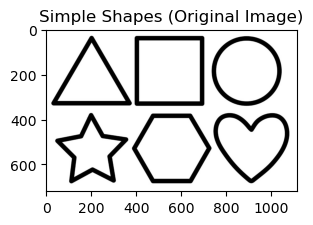

In [8]:
matplotlib_imshow("Simple Shapes (Original Image)", shape_img, 5)

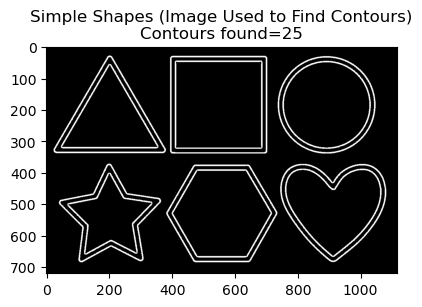

In [9]:
matplotlib_imshow(
    f"Simple Shapes (Image Used to Find Contours)\nContours found={len(shape_img_contours)}",
    img_used,
    7,
)
# no need to convert color space since matplotlib_imshow does that
# if we were to use plt.imshow() we need to convert color space for correct representation of the colors

- ### Drawing Contours

> The `cv.drawContours(image, contours, contourIdx, color, thickness)` function

<u>Function Parameters</u>
- image: image to draw contours on.
- contours: all the input contours.
- contourIdx: index of the contour to be drawn. If it is negative, all the contours are drawn.
- color: color of the drawn contours.
- thickness: thickness of the lines contours are drawn with.

**`Note:`** Draws on the source image i.e, modifies the source image inplace. So be careful.

In [10]:
def get_canvas(shape, color_code=(80, 80, 80)):
    return np.full(shape, fill_value=color_code, dtype=np.uint8)

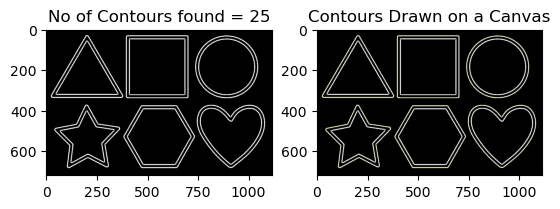

In [11]:
plt.subplot(1, 2, 1).imshow(cv.cvtColor(img_used, cv.COLOR_BGR2RGB)), plt.title(
    f"No of Contours found = {len(shape_img_contours)}"
)

plt.subplot(1, 2, 2).imshow(
    cv.drawContours(
        cv.cvtColor(img_used, cv.COLOR_BGR2RGB),
        shape_img_contours,
        -1,
        (200, 200, 0),
        thickness=1,
    )
), plt.title("Contours Drawn on a Canvas")

plt.show()

In [12]:
# a function to draw all the detected contours one by one with 1 second pause after each one is drawn
def draw_all_contours_one_by_one(
    canvas_shape,
    contours,
    idx=-1,
    color=(200, 0, 0),
    thickness=1,
    time_to_pause_in_between=1,
):
    # to draw every contour on the same canvas
    # canvas = get_canvas(canvas_shape)
    for i, cnt in enumerate(contours):
        # to draw each one in a completely blank canvas
        canvas = get_canvas(canvas_shape)
        cv.drawContours(canvas, [cnt], idx, color, thickness)
        plt.imshow(canvas)
        plt.title(f"Contour = {i}")
        plt.pause(0.5)
        plt.show()

In [13]:
# %matplotlib qt
# draw_all_contours_one_by_one(shape_img.shape, shape_img_contours)

## Contour Features ([Docs](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html))

- ### Moment

An image moment is a certain particular weighted average (moment) of the image pixels' intensities, or a function of such moments. It is calculated similarly to how first moment of an area would be calculated. 

Simple properties of the image which are found via image moments include area (or total intensity), its centroid, and information about its orientation.

> The function `cv.moments(cnt)` gives a dictionary of all moment values calculated for that particular contour.

Out of all the values this function returns, three of the most important values are returned with the following keys -- 
1. 'm00': Area (for binary images) or sum of grey level (for greytone images)
2. 'm10': First moment of area about the x axis
3. 'm01': First moment of area about the y axis

These can be used to calculate the centroid of a contour as, (`cx= 'm10'/'m00'`, `cy= 'm01'/'m00'`).

In [14]:
moment_of_all_contours = {
    cnt_i: cv.moments(cnt) for cnt_i, cnt in enumerate(shape_img_contours)
}

In [15]:
moment_of_all_contours[0]

{'m00': 0.0,
 'm10': 0.0,
 'm01': 0.0,
 'm20': 0.0,
 'm11': 0.0,
 'm02': 0.0,
 'm30': 0.0,
 'm21': 0.0,
 'm12': 0.0,
 'm03': 0.0,
 'mu20': 0.0,
 'mu11': 0.0,
 'mu02': 0.0,
 'mu30': 0.0,
 'mu21': 0.0,
 'mu12': 0.0,
 'mu03': 0.0,
 'nu20': 0.0,
 'nu11': 0.0,
 'nu02': 0.0,
 'nu30': 0.0,
 'nu21': 0.0,
 'nu12': 0.0,
 'nu03': 0.0}

In [16]:
# As we can see, there's clearly some contours with m00=0 i.e, area=0. Let's filter them out.
contours_with_zero_area = [
    i
    for i in range(len(moment_of_all_contours))
    if moment_of_all_contours[i].get("m00") == 0
]
contours_with_zero_area

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 21]

In [17]:
# Let's remove these items from shape_img_contours

**`Note:`** See this article @https://www.geeksforgeeks.org/python-remove-elements-at-indices-in-list/

In [18]:
# we will use tuple comprehension to create a new list of contours that has area > 0.
# This way the original one won't be changed.
contours_gt_zero_area = tuple(
    elem
    for i, elem in enumerate(shape_img_contours)
    if i not in contours_with_zero_area
)

In [19]:
shape_img_contours = contours_gt_zero_area

In [20]:
len(shape_img_contours)

10

In [21]:
# now let's see the change
shape_contours_moments = [cv.moments(cnt) for cnt in shape_img_contours]
moment_of_valid_contour_0 = shape_contours_moments[0]
moment_of_valid_contour_0

{'m00': 9.5,
 'm10': 4.333333333333333,
 'm01': 6079.166666666666,
 'm20': 2.75,
 'm11': 2773.7916666666665,
 'm02': 3890269.25,
 'm30': 2.0,
 'm21': 1760.6,
 'm12': 1775577.6666666667,
 'm03': 2489604744.55,
 'mu20': 0.7733918128654975,
 'mu11': 0.8384502923981927,
 'mu02': 135.84356725215912,
 'mu30': 0.04006360931568698,
 'mu21': 0.07632604904046048,
 'mu12': -4.183312814547918,
 'mu03': -179.69528102874756,
 'nu20': 0.008569438369700802,
 'nu11': 0.009290307949010444,
 'nu02': 1.5051918809103502,
 'nu30': 0.0001440260529378038,
 'nu21': 0.0002743871500197179,
 'nu12': -0.015038735729872426,
 'nu03': -0.6459927724980649}

- ### Centroid of a Contour

In [22]:
cx = moment_of_valid_contour_0["m10"] / moment_of_valid_contour_0["m00"]
cy = moment_of_valid_contour_0["m01"] / moment_of_valid_contour_0["m00"]
print(f"Centroid of the 0th Valid contour of the Shapes Image is, {cx, cy}")

Centroid of the 0th Valid contour of the Shapes Image is, (0.45614035087719296, 639.9122807017543)


- ### Contour Area

> The function `cv.contuorArea(cnt)` gives the Contour Area or can be found from `M['m00']`

In [23]:
area_of_contour_0 = cv.contourArea(shape_img_contours[0])

In [24]:
area_of_contour_0

9.5

**Controlling which contour to draw based on its area --**

In [25]:
canvas = get_canvas(shape_img.shape)

In [26]:
top_3_cnts_by_area = sorted(shape_img_contours, key=cv.contourArea, reverse=True)[:3]
top_3_cnts_area = [cv.contourArea(cnt) for cnt in top_3_cnts_by_area]

In [27]:
top_3_cnts_area

[95120.5, 82151.5, 75175.5]

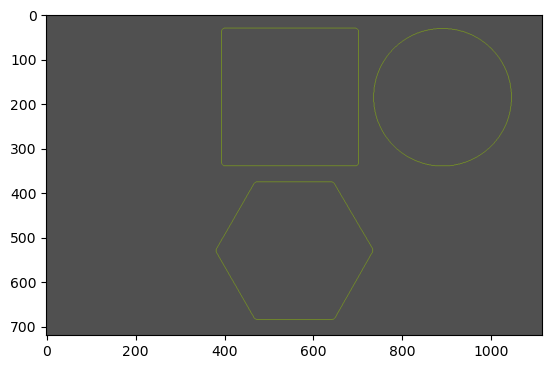

In [28]:
plt.imshow(cv.drawContours(canvas, top_3_cnts_by_area, -1, (150, 200, 0)))

- ### Contour Perimeter

> The function `cv.arcLength(cnt, closed)`

Contour perimeter is also called arc length. It can be found out using cv.arcLength() function. Second argument specify whether shape is a closed contour (if passed True), or just a curve. 

In [29]:
cv.arcLength(shape_img_contours[0], True)

39.071067690849304

## Contour Approximation

It approximates a contour shape to another shape with less number of vertices so that the distance between them is less or equal to the specified precision. It is an implementation of Douglas-Peucker algorithm. 

The Ramer–Douglas–Peucker algorithm, also known as the Douglas–Peucker algorithm and iterative end-point fit algorithm, is an algorithm that decimates a curve composed of line segments to a similar curve with fewer points.

The purpose of the algorithm is, given a curve composed of line segments (which is also called a Polyline in some contexts), to find a similar curve with fewer points. The algorithm defines 'dissimilar' based on the maximum distance between the original curve and the simplified curve (i.e., the Hausdorff distance between the curves). The simplified curve consists of a subset of the points that defined the original curve. 

> The `cv.approxPolyDP(curve, epsilon, closed)` function for Contour Approximation

<u>Function Parameters</u>
- curve: Input vector of a 2D point
- epsilon: Parameter specifying the approximation accuracy. This is the maximum distance between the original curve and its approximation.
- closed: If true, the approximated curve is closed (its first and last vertices are connected). Otherwise, it is not closed. 

In [30]:
star_img, star_img_used, star_contours, star_hierarchy = find_contours(
    "./imgs/star.jpeg", cv.RETR_CCOMP
)

In [31]:
canvas = get_canvas(star_img.shape)

In [32]:
# drawing all the contours of star_contours onto the canvas
cv.drawContours(canvas, star_contours, -1, (150, 200, 0), thickness=3)

# using cv.approxPloyDP() we try to find a start that has sharp edges
for cnt in star_contours:
    accuracy = 0.01 * cv.arcLength(cnt, True)
    approximated_contour = cv.approxPolyDP(cnt, accuracy, True)
    cv.drawContours(canvas, [approximated_contour], 0, (0, 200, 100), thickness=3)

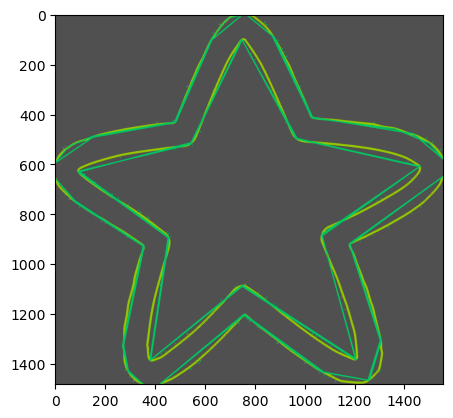

In [33]:
# showing the result
plt.imshow(canvas)

## Convex Hull

Given a set of points on a two dimensional plane, Convex Hull of this set of points is a polygon that encloses all of those points. The vertices of this polygon maximizes the area while minimizing the circumference.

<img src="./imgs/convex_hull.png">

> The `cv.convexHull(points, clockwise, returnPoints)` function

<u>Function Parameters</u>
- points: a set of points around which the convex hull is to be found. The contours we pass into.
- clockwise: Orientation flag. If it is True, the output convex hull is oriented clockwise. Otherwise, it is oriented counter-clockwise. 
- returnPoints : By default, True. Then it returns the coordinates of the hull points. If False, it returns the indices of contour points corresponding to the hull points.

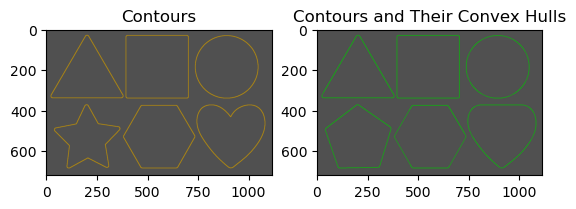

In [34]:
canvas_1 = get_canvas(shape_img.shape)
canvas_2 = get_canvas(shape_img.shape)
for cnt in shape_img_contours:
    hull = cv.convexHull(cnt)
    plt.subplot(1, 2, 1).imshow(
        cv.drawContours(canvas_1, [cnt], -1, (200, 150, 0), 2)
    ), plt.title("Contours")
    plt.subplot(1, 2, 2).imshow(
        cv.drawContours(canvas_2, [hull], -1, (0, 200, 0), 2)
    ), plt.title("Contours and Their Convex Hulls")
plt.show()

## Match Shapes ([Docs](https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html))

OpenCV comes with a function cv.matchShapes() which enables us to compare two shapes, or two contours and returns a metric showing the similarity. The lower the result, the better match it is. It is calculated based on the hu-moment values.

Hu-Moments are seven moments invariant to translation, rotation and scale. Seventh one is skew-invariant. Those values can be found using `cv.HuMoments()` function.

> The `cv.matchShapes(cnt1, cnt2, method)` function

<u>Function Parameters</u>
- method: Shape matching methods ([Docs](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gaf2b97a230b51856d09a2d934b78c015f)). 
    - cv.CONTOURS_MATCH_I1
    - cv.CONTOURS_MATCH_I2
    - cv.CONTOURS_MATCH_I3
- parameter: Method-specific parameter

In [35]:
# we will go through the whole process of finding contours manually (just for paractice)
img = cv.imread("./imgs/simple_shapes.png")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_blurred = cv.GaussianBlur(img_gray, (5, 5), sigmaX=0)
otsu_thresh_val, img_thresholded = cv.threshold(
    img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)
# as the object are orginally black we need to invert the image to properly find contours
img_to_use = cv.bitwise_not(img_thresholded)

In [36]:
# for complex shapes where you fear that storing only 2 end points will not suffice use, cv.CHAIN_APPROX_NONE
img_contours, img_hierarchy = cv.findContours(
    img_to_use, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE
)

In [37]:
heart_shaped_cnt = img_contours[1]
star_shaped_cnt = img_contours[2]

In [38]:
# convex hull of these two contours
heart_hull_cnt = cv.convexHull(heart_shaped_cnt)
star_hull_cnt = cv.convexHull(star_shaped_cnt)

In [39]:
# numpy stores data as, (rows, columns)
# opencv stores data as, (width, height)
# so it is opposite of what numpy does
canvas = get_canvas(shape_img.shape)

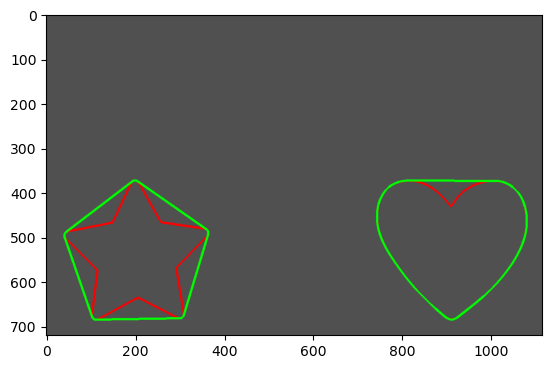

In [40]:
# contours
cv.drawContours(canvas, [star_shaped_cnt], -1, (255, 0, 0), 3)
cv.drawContours(canvas, [heart_shaped_cnt], -1, (255, 0, 0), 3)

# hulls
cv.drawContours(canvas, [star_hull_cnt], -1, (0, 255, 0), 3)
cv.drawContours(canvas, [heart_hull_cnt], -1, (0, 255, 0), 3)

plt.imshow(canvas)

In [41]:
cv.matchShapes(heart_shaped_cnt, heart_hull_cnt, cv.CONTOURS_MATCH_I1, 0)

0.08634698316527323

In [42]:
cv.matchShapes(star_shaped_cnt, star_hull_cnt, cv.CONTOURS_MATCH_I1, 0)

0.0943244676029884